# Time Series Analysis

## Part I. Research Question

### A1.

Will we be able to determine a revenue pattern from the first two years of operation?

### A2.

The objective for this project is to perform a time series analysis in order to find any possible patterns within the dataset's day and revenue variable. Then with our statistical results, use it to predict future outcomes.

## Part II. Method Justification

### B. Summary of Assumptions

The assumptions of the Time Series Model are that the data are stationary and have autocorrelation. Stationary is defined as the statistical properties(mean, variance, and autocorrelation structure) of a time series should remain constant over time. The autocorrelation structure is defined as any value at any given point in time, should correlate with its value at a previous point in time (6.4.4.2. Stationarity, n.d.).


## Part III: Data Preparation

#Install and ensure we have the libraries needed. Has been Markdown for faster execution
!pip install numpy
!pip install scipy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install pandas
!pip install apyori
!pip install mlxtend
!pip install pmdarima
!pip install fbprophet

In [1]:
# Import libraries needed.
import numpy as np
import pandas as pd
import scipy.stats as stats
from pandas import DataFrame

import matplotlib.pyplot as plt
import seaborn as sns

from dateutil.parser import parse

import statsmodels.api as sm
#Import for Spectral Density
from scipy import signal
#To do a stationary model
import statsmodels.tsa.stattools as adfuller
#Use for seasonal/trend plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
#Use for the Autocorrelation
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
#Use for the ARIMA Model
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
#Ignore Harmless warnings
import warnings
warnings.filterwarnings("ignore")
#Import Sarimax for Additional ARIMA Analysis
from statsmodels.tsa.statespace.sarimax import SARIMAX
#Import Evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from math import sqrt
#Import Facebook Prophet
from prophet import Prophet

In [2]:
#Import the dataset into Pandas DataFrame and display it.
df=pd.read_csv('d213_teleco_time_series.csv')
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [3]:
#List total number of entries in dataset (RowsxColumn).
print(df.shape)

(731, 2)


In [4]:
#Display the datatype for each column.
print(df.dtypes)

Day          int64
Revenue    float64
dtype: object


In [5]:
#Look at the basic statistics of the dataset.
df.describe()

,Day,Revenue
count,731.000000,731.000000
mean,366.000000,9.822901
std,211.165812,3.852645
min,1.000000,0.000000
25%,183.500000,6.872836
50%,366.000000,10.785571
75%,548.500000,12.566911
max,731.000000,18.154769


In [6]:
#Perform checks to see if null values exists.
print(df.isna().sum())


Day        0
Revenue    0
dtype: int64


In [7]:
#Check for duplicate rows
df.duplicated().sum()

0

In [8]:
#List total number of entries in dataset (RowsxColumn).
print(df.shape)

(731, 2)


In [9]:
df.set_index('Day',inplace=True)

In [10]:
df.index=pd.to_datetime(df.index, unit = 'D', origin = '2020-01-01')
df

,Revenue
Day,
2020-01-02,0.000000
2020-01-03,0.000793
2020-01-04,0.825542
2020-01-05,0.320332
2020-01-06,1.082554
...,...
2021-12-28,16.931559
2021-12-29,17.490666
2021-12-30,16.803638


### C1. Line Graph Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

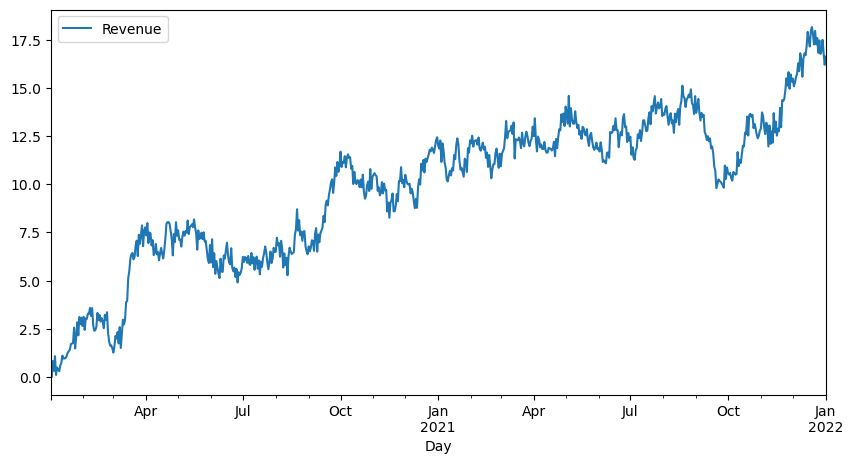

In [11]:
df.plot(y = 'Revenue', figsize=(10,5))
plt.show

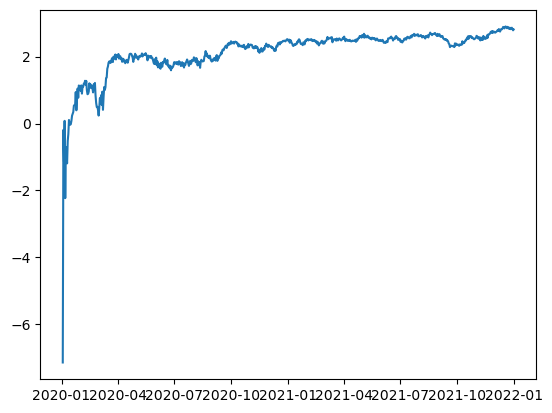

In [12]:
#Plot using Log
lndf = np.log(df)
lndf
plt.plot(lndf)
plt.show()


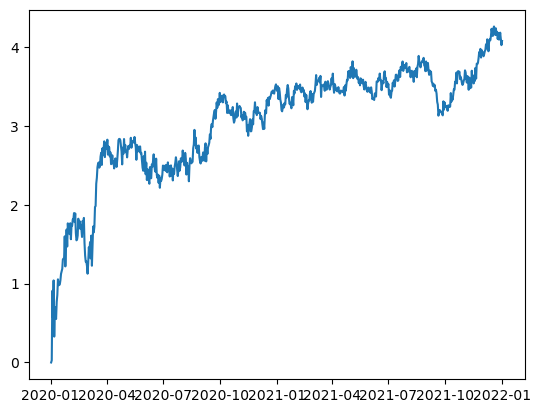

In [13]:
#Plot using Sqrt
sqrtdf = np.sqrt(df)
plt.plot(sqrtdf)
plt.show()

### C2. Time Step Formatting

Initial review of the line graph, determined that there were no gaps or missing periods. Review of the data set and visualization shows that all data was evenly spaced (data for each day) and that there were no missing or unusual data. Visualization does seem to show that the dataset is not Stationary. The length of the data is 0-731 in days with 731 total rows and 2 columns.

In [14]:
#Test Stationarity with Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
print("Dickey-fuller Test Results")
adftest = adfuller(df['Revenue'],autolag='AIC')
adfoutput=pd.Series(adftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in adftest[4].items():
    adfoutput['critical value (%s)'%key]= value
print(adfoutput)

Dickey-fuller Test Results
Test Statistic                  -1.924612
p-value                          0.320573
#lags used                       1.000000
number of observations used    729.000000
critical value (1%)             -3.439352
critical value (5%)             -2.865513
critical value (10%)            -2.568886
dtype: float64


### Part III-C3. Evaluation of Stationary

Reviewing the Test results above, we can see that the Test Statistics value (-1.92) is greater than each of its critical value(1% = -3.43, 5% = -2.86, 10% = -2.56) which indicates that the timeseries is not stationary. A p-value>0.05 is also an indication of non-stationary data.

### Part III-C4. Data Preparation Steps

From here, we will be applying the diff() function on the dataset and using the Dickey Fuller test again in hopes to achieve a better critical value as well as a significant p-value. Then after establishing data stationary, we will next create Train/Test datasets in preparation for forecasting and other statstical analysis.

In [15]:
#Use pandas diff() function to make the time series stationary
df_diff = df.diff().dropna()
df_diff

,Revenue
Day,
2020-01-03,0.000793
2020-01-04,0.824749
2020-01-05,-0.505210
2020-01-06,0.762222
2020-01-07,-0.974900
...,...
2021-12-28,0.170280
2021-12-29,0.559108
2021-12-30,-0.687028


In [16]:
df_final = pd.DataFrame(df_diff, columns = ['Revenue'])


In [17]:
#Recheck dataset to ensure no null values
df_final.isna().sum()

Revenue    0
dtype: int64

In [18]:
#Check for duplicates as well
df_final.duplicated().sum()

0

<function matplotlib.pyplot.show(close=None, block=None)>

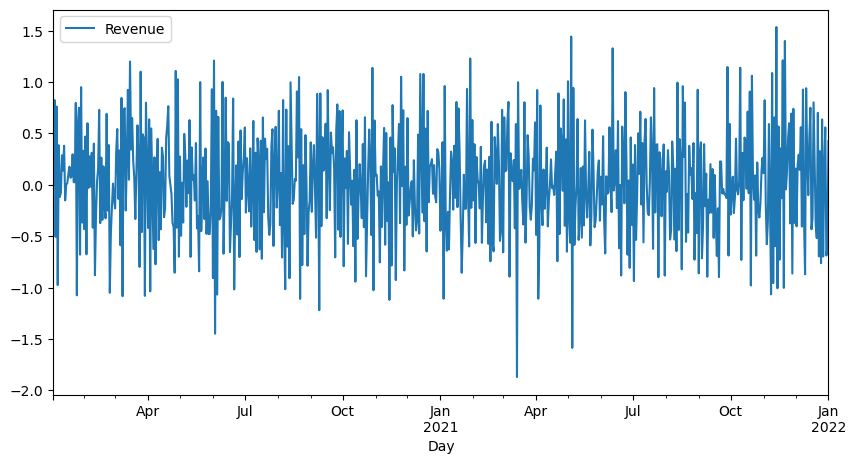

In [19]:
#Plotting Data Set again to Visualize Stationary
df_final.plot(y = 'Revenue', figsize=(10,5))
plt.show

In [20]:
#Test Stationarity with Dickey Fuller Test
from statsmodels.tsa.stattools import adfuller
print("Dickey-fuller Test Results")
adftest = adfuller(df_final['Revenue'],autolag='AIC')
adfoutput=pd.Series(adftest[0:4],index=['Test Statistic','p-value','#lags used','number of observations used'])
for key,value in adftest[4].items():
    adfoutput['critical value (%s)'%key]= value
print(adfoutput)

Dickey-fuller Test Results
Test Statistic                 -44.874527
p-value                          0.000000
#lags used                       0.000000
number of observations used    729.000000
critical value (1%)             -3.439352
critical value (5%)             -2.865513
critical value (10%)            -2.568886
dtype: float64


Reviewing the values above, we can see that the Test Statistic value (-44.87) is now much lower than the critical values(1% = 3.43, 5% = -2.86, 10% = -2.56) and the pvalue is now statistically significant (p<0.05). We can continue on now that we have establish data stationary.

In [21]:
#Create Train Test Dataset
df_train, df_test= np.split(df_final, [int(.8 *len(df_final))])
print('Observations: %d' % (len(df_final)))
print('Training Observations: %d' % (len(df_train)))
print('Testing Observations: %d' % (len(df_test)))

Observations: 730
Training Observations: 584
Testing Observations: 146


In [22]:
#Create start/end variable for future use
start = len(df_train)
end = len(df_train) + len(df_test) - 1

In [23]:
#View the df_train dataset
df_train

,Revenue
Day,
2020-01-03,0.000793
2020-01-04,0.824749
2020-01-05,-0.505210
2020-01-06,0.762222
2020-01-07,-0.974900
...,...
2021-08-04,0.113264
2021-08-05,-0.531705
2021-08-06,-0.437835


In [24]:
#View the df_train dataset
df_test

,Revenue
Day,
2021-08-09,-0.531923
2021-08-10,0.157387
2021-08-11,-0.644689
2021-08-12,0.995057
2021-08-13,-0.438775
...,...
2021-12-28,0.170280
2021-12-29,0.559108
2021-12-30,-0.687028


### C5. Export Prepared Dataset

In [25]:
#Export Dataset and Train Test Datasets
df_final.to_csv('D213_Cleaned_Telco_TimeSeries.csv')
df_train.to_csv('D213_Train_Dataset.csv')
df_test.to_csv('D213_Test_Dataset.csv')

## Part. IV: Model Identification and Analysis


### D1: Report Findings and Visualization

#### Decomposed Time Series

Reviewing the full Seasonal Decomposition below, there seems to be some seasonality in the data. The trend as well as the residual plot does not show any visible trends.

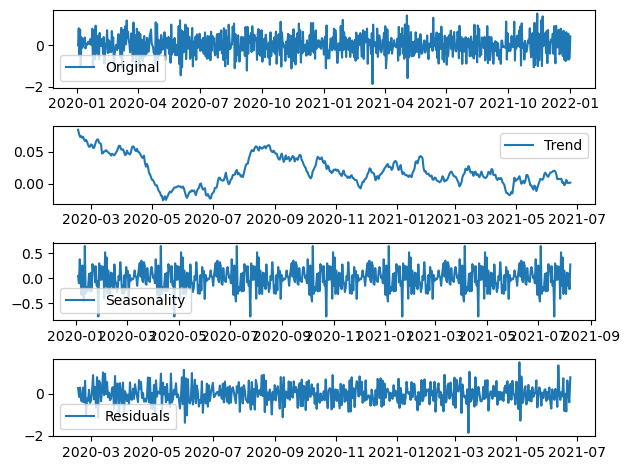

In [26]:
#Plot the decomposition of the Time Series
decomp_result = seasonal_decompose(df_train['Revenue'], model='additive', period = 90)

trend = pd.Series(decomp_result.trend)
season = pd.Series(decomp_result.seasonal)
res = pd.Series(decomp_result.resid)

plt.subplot(411)
plt.plot(df_final, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(season, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(res, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Seasonal Component

<Axes: xlabel='Day'>

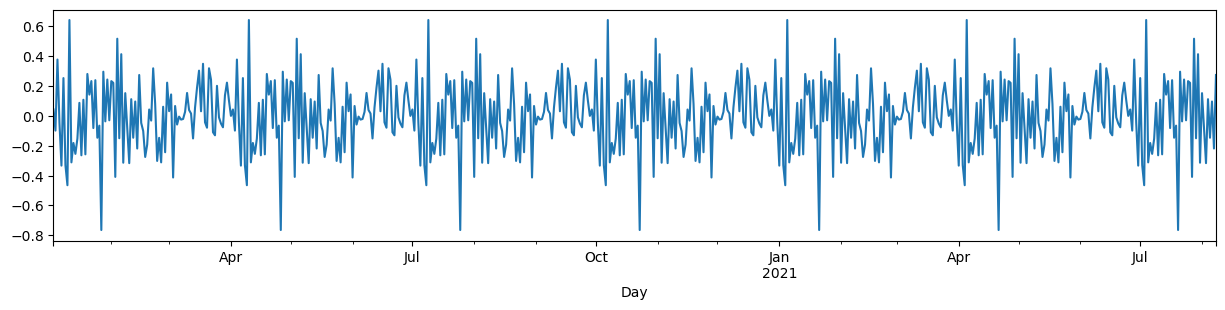

In [27]:
#Plot seasonality visualization
decomp_result.seasonal.plot(figsize=(15, 3))

Reviewing the visualization above closer still indicates some form of seasonality in the data.

#### Trends

Reviewing the visualization below, there doesn't seem to be a trend represented in our data.

<Axes: xlabel='Day'>

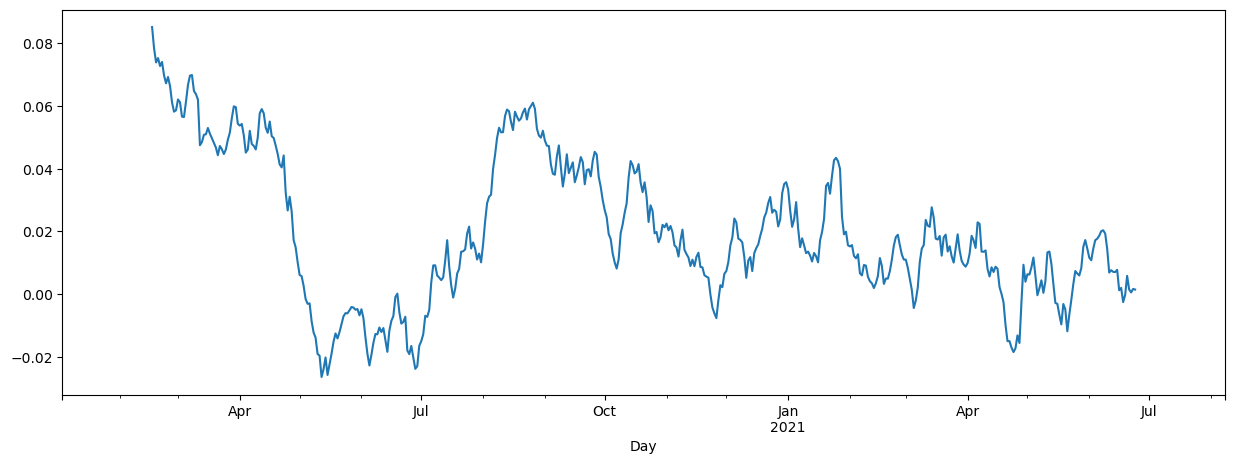

In [28]:
#Plot a trend visualization
decomp_result.trend.plot(figsize=(15, 5))

#### Autocorrelation Function

In [29]:
#Autocorrelation Function
sm.tsa.acf(df_final['Revenue'], nlags = 5)

array([ 1.        , -0.46950565,  0.22387382, -0.0766203 ,  0.04784273,
       -0.0345083 ])

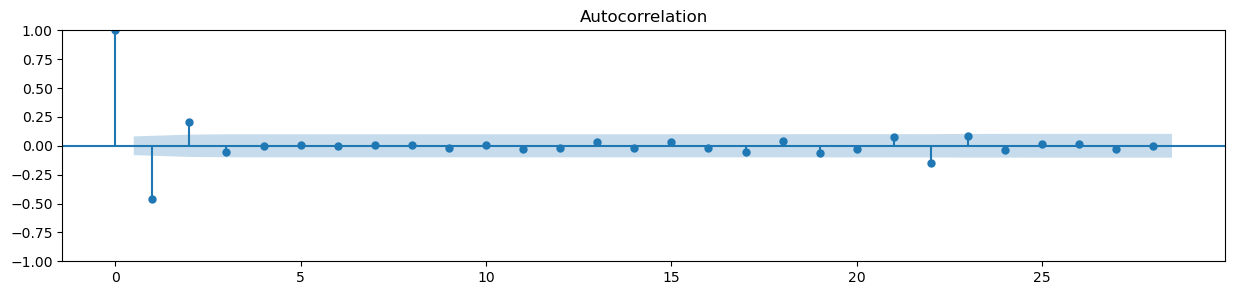

In [30]:
#Plot Autocorrelation
fig = plot_acf(df_train)
fig.set_size_inches(15, 3)
plt.show(fig)

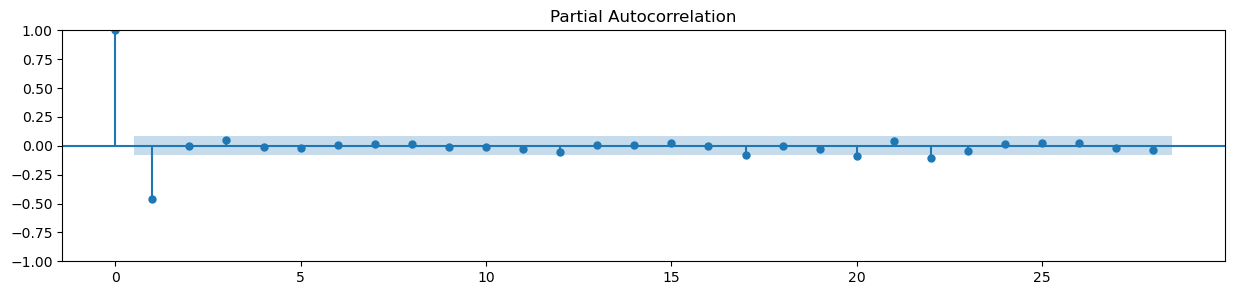

In [31]:
# Partial Autocorrelation Plot
fig2 = plot_pacf(df_train)
fig2.set_size_inches(15, 3)
plt.show(fig2)

#### Spectral Density and Rolling Average

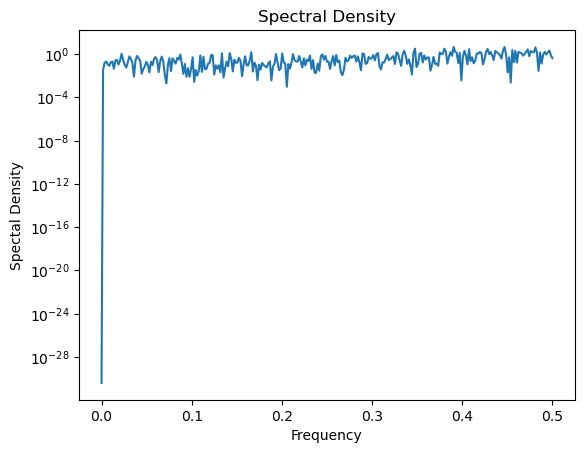

In [32]:
#Plot Spectral Density
f, Pxx_den = signal.periodogram(df_train['Revenue'])
plt.semilogy(f, Pxx_den)
plt.title('Spectral Density')
plt.xlabel('Frequency')
plt.ylabel('Spectal Density')
plt.show()

Visualization comparison of our initial dataset against rolling average.

<Axes: xlabel='Day'>

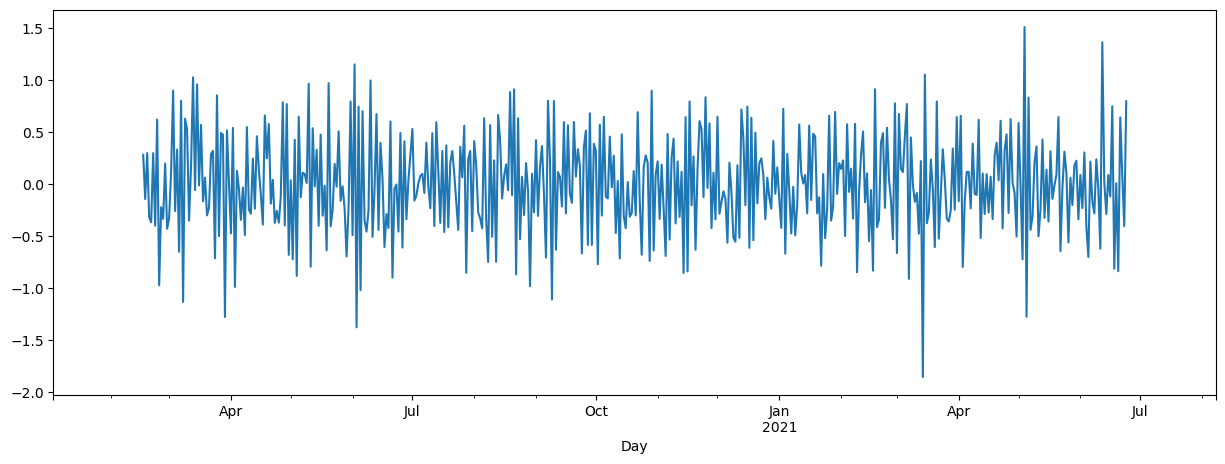

In [33]:
#Plot a resid visualization
decomp_result.resid.plot(figsize=(15, 5))

In [34]:
#Create 7 day rolling avg. Null values are expected for the first 7 days.
df_rollavg = df_train.copy()
df_rollavg[ '7day_average' ] = df_rollavg.Revenue.rolling( 7).mean()
df_rollavg

,Revenue,7day_average
Day,,
2020-01-03,0.000793,NaN
2020-01-04,0.824749,NaN
2020-01-05,-0.505210,NaN
2020-01-06,0.762222,NaN
2020-01-07,-0.974900,NaN
...,...,...
2021-08-04,0.113264,0.016776
2021-08-05,-0.531705,-0.072031
2021-08-06,-0.437835,-0.190822


Text(0.5, 0, 'Day')

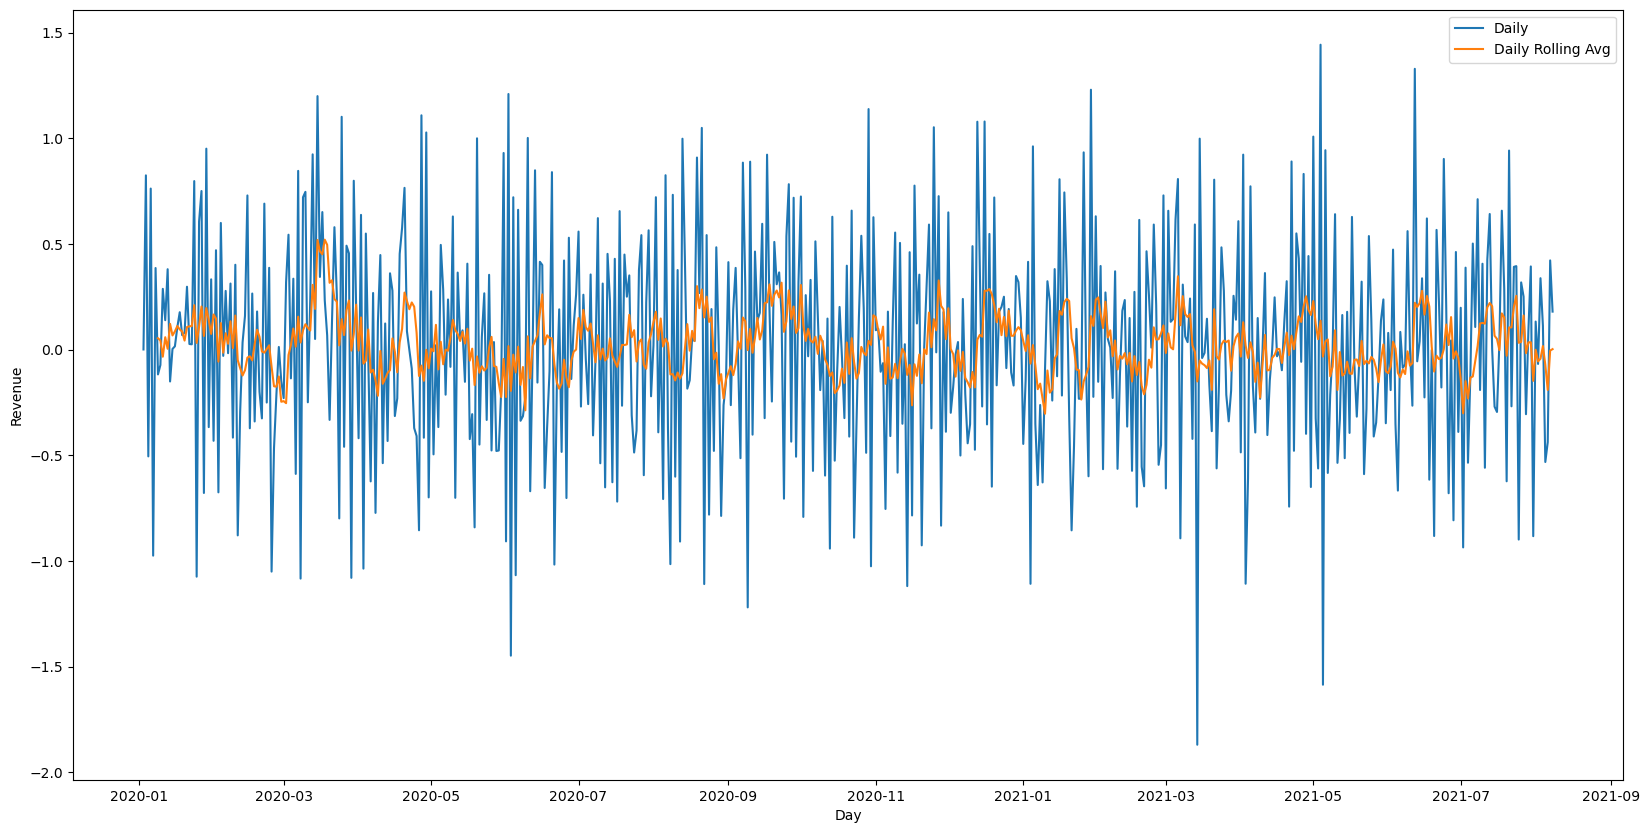

In [35]:
#Plot Rolling average on top dataset.

plt.figure(figsize = (20, 10))

sns.lineplot(x = 'Day', y = 'Revenue', data = df_rollavg, label = 'Daily')

sns.lineplot(x = 'Day', y = '7day_average', data = df_rollavg, label = 'Daily Rolling Avg')

plt.xlabel('Day')

#### Lack of Trends in Residuals

Reviewing the residual visualization above, we stil can see that there is a lack of trends in the residual plot.

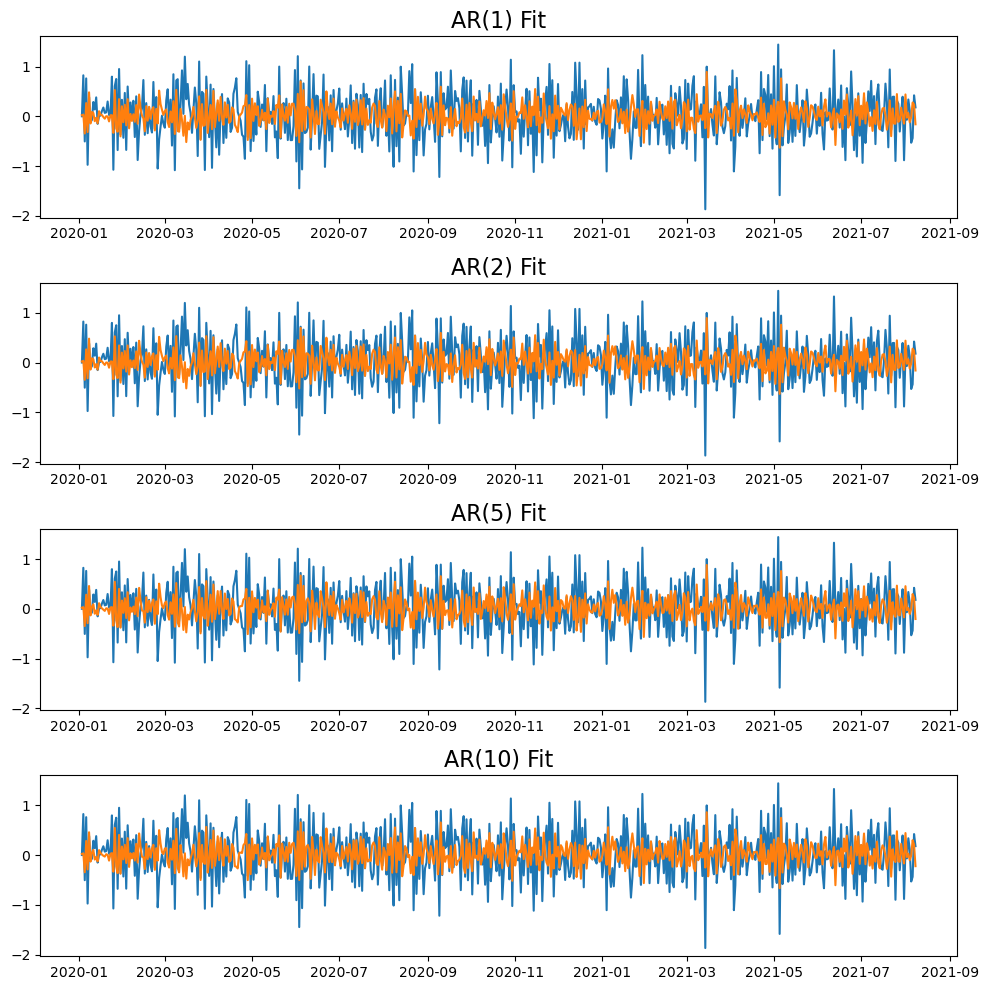

In [36]:
#Plot and Compare AR Model
plt.figure(figsize=(10,10))

ar_orders = [1,2,5,10]
fitted_model_dict = {}
for idx, ar_order in enumerate(ar_orders):
    ar_model = sm.tsa.arima.ARIMA(df_train, order=(ar_order,0,0))
    ar_model_fit = ar_model.fit()
    fitted_model_dict[ar_order] = ar_model_fit
    plt.subplot(4,1,idx+1)
    plt.plot(df_train)
    plt.plot(ar_model_fit.fittedvalues)
    plt.title('AR(%s) Fit'%ar_order, fontsize=16)
    
plt.tight_layout()

In [37]:
# AIC comparision
for ar_order in ar_orders:
    print('AR(%s) AIC: %s'%(ar_order, fitted_model_dict[ar_order].aic))

AR(1) AIC: 773.8925878321593
AR(2) AIC: 775.8863459233254
AR(5) AIC: 779.9171059196162
AR(10) AIC: 789.5442248726788


In [38]:
# BIC comparision
for ar_order in ar_orders:
    print('AR(%s) BIC: %s'%(ar_order, fitted_model_dict[ar_order].bic))

AR(1) BIC: 787.002290780644
AR(2) BIC: 793.3659498546383
AR(5) BIC: 810.5064127994139
AR(10) BIC: 841.9830366666175


In [39]:
#AR model
model_train = sm.tsa.arima.ARIMA(df_train, order=(1,0,0))
results_train=model_train.fit()
print(results_train.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Sat, 19 Aug 2023   AIC                            773.893
Time:                        13:11:51   BIC                            787.002
Sample:                    01-03-2020   HQIC                           779.002
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.0

<Axes: xlabel='Day'>

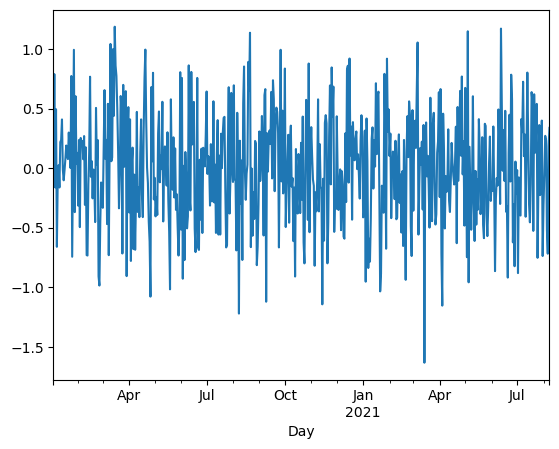

In [40]:
#Model Residual
results_train.resid.plot()

### Auto ARIMA

In [41]:
# Fit auto_arima function to dataset
model_aa = auto_arima(df_train, seasonal = True,
                          trace = True, m = 90, D=0,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          )  # set to stepwise
                           

# To print the summary
model_aa.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[90] intercept   : AIC=777.454, Time=18.01 sec
 ARIMA(0,0,0)(0,0,0)[90] intercept   : AIC=910.790, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[90] intercept   : AIC=771.587, Time=4.45 sec
 ARIMA(0,0,1)(0,0,1)[90] intercept   : AIC=798.728, Time=4.41 sec
 ARIMA(0,0,0)(0,0,0)[90]             : AIC=909.948, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[90] intercept   : AIC=773.893, Time=0.09 sec
 ARIMA(1,0,0)(2,0,0)[90] intercept   : AIC=773.587, Time=18.63 sec
 ARIMA(1,0,0)(1,0,1)[90] intercept   : AIC=773.587, Time=7.93 sec
 ARIMA(1,0,0)(0,0,1)[90] intercept   : AIC=771.605, Time=4.49 sec
 ARIMA(1,0,0)(2,0,1)[90] intercept   : AIC=775.587, Time=24.31 sec
 ARIMA(0,0,0)(1,0,0)[90] intercept   : AIC=912.297, Time=2.31 sec
 ARIMA(2,0,0)(1,0,0)[90] intercept   : AIC=773.558, Time=4.57 sec
 ARIMA(1,0,1)(1,0,0)[90] intercept   : AIC=773.564, Time=5.24 sec
 ARIMA(0,0,1)(1,0,0)[90] intercept   : AIC=798.743, Time=4.18 sec
 ARIMA(2,0,1)(1,0,0)[90] inter

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  584
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -381.794
Date:                            Sat, 19 Aug 2023   AIC                            771.587
Time:                                    13:13:49   BIC                            789.067
Sample:                                01-03-2020   HQIC                           778.400
                                     - 08-08-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0319      0.019      1.673      0.094      -0.005       0.069
ar.L1         -0.4681      0.037    -12.555      0.000      -0.541      -0.395
ar.S.L90       0.0929      0.043      2.157      0.031       0.008       0.177
sigma2         0.2161      0.013     16.159      0.000       0.190       0.242
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.92   Prob(JB):                         0.65
Heteroskedasticity (H):               0.98   Skew:                            -0.06
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

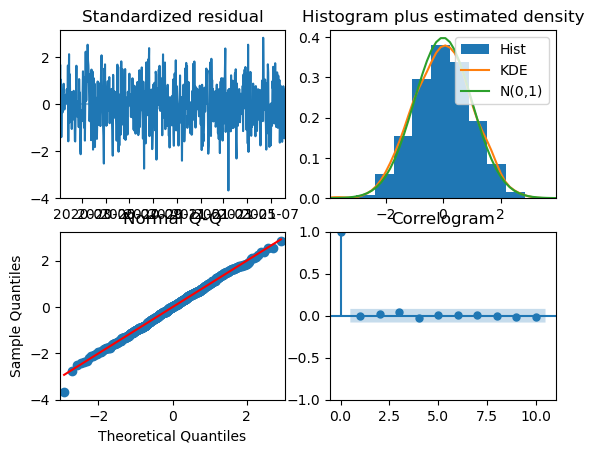

In [42]:
model_aa.plot_diagnostics()
plt.show()

In [43]:
#Review Initial ARIMA model as suggested by Auto ARIMA
model_i = ARIMA(df_train,order = (1, 0, 0), 
                    seasonal_order=(1,0,0,90))
results_i=model_i.fit()
print(results_i.summary())
print(results_i.params)

                                    SARIMAX Results                                     
Dep. Variable:                          Revenue   No. Observations:                  584
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -381.794
Date:                          Sat, 19 Aug 2023   AIC                            771.587
Time:                                  13:13:54   BIC                            789.067
Sample:                              01-03-2020   HQIC                           778.400
                                   - 08-08-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.014      1.677      0.093      -0.004       0.052
ar.L1         -0.4680      0.037    -12.555      0.

In [44]:
#ARIMA on Test Dataset
model_it = ARIMA(df_test,order = (1, 0, 0), 
                    seasonal_order=(1,0,0,90))
results_it=model_it.fit()
print(results_it.summary())
print(results_it.params)

                                    SARIMAX Results                                     
Dep. Variable:                          Revenue   No. Observations:                  146
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -104.071
Date:                          Sat, 19 Aug 2023   AIC                            216.142
Time:                                  13:13:56   BIC                            228.076
Sample:                              08-09-2021   HQIC                           220.991
                                   - 01-01-2022                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0194      0.027      0.709      0.478      -0.034       0.073
ar.L1         -0.5056      0.078     -6.503      0.

In [45]:
#Review Initial SARIMAX model
model_s =SARIMAX(df_train['Revenue'], order = (1, 0, 0))
results_s=model_s.fit()
print(results_s.summary())
print(results_s.params)

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -385.495
Date:                Sat, 19 Aug 2023   AIC                            774.990
Time:                        13:13:56   BIC                            783.730
Sample:                    01-03-2020   HQIC                           778.397
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.036    -12.605      0.000      -0.528      -0.386
sigma2         0.2191      0.014     15.965      0.000       0.192       0.246
Ljung-Box (L1) (Q):                   0.02   Jarque-

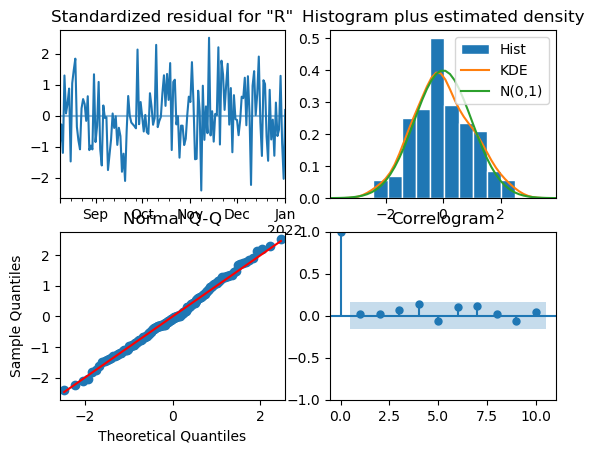

In [46]:
#Review Plot Diagnostic
results_it.plot_diagnostics()
plt.show()

In [47]:
def stationary_test(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()

    rolstd = pd.Series(timeseries).rolling(window=12).std()
#Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='orange', label='Rolling Mean')
    plt.plot(rolstd, color='red', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print('Dickey-Fuller Test Result:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

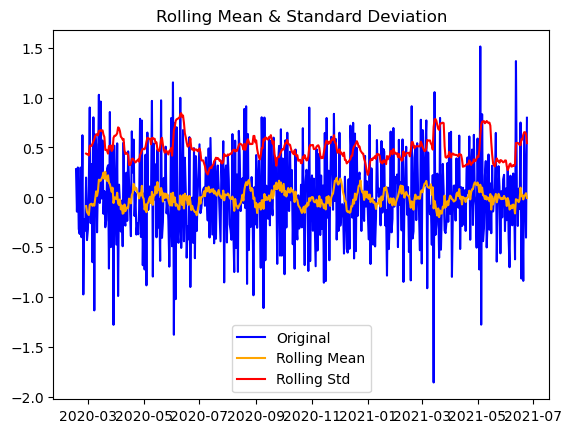

Dickey-Fuller Test Result:
Test Statistic         -1.356982e+01
p-value                 2.226063e-25
#Lags Used              2.000000e+00
Observations Used       4.910000e+02
Critical Value (1%)    -3.443739e+00
Critical Value (5%)    -2.867444e+00
Critical Value (10%)   -2.569915e+00
dtype: float64


In [48]:
df_decompN = res
df_decompN.dropna(inplace=True)
stationary_test(df_decompN)

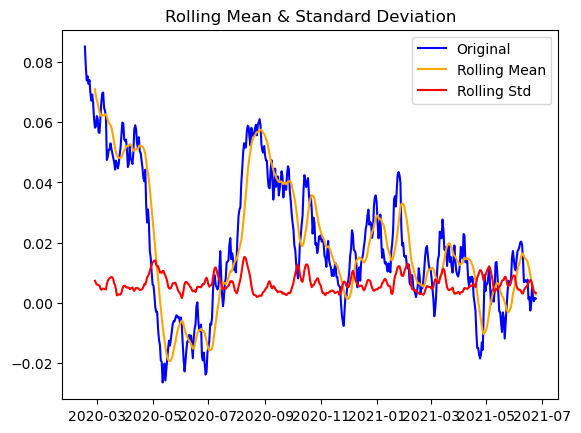

Dickey-Fuller Test Result:
Test Statistic           -2.496038
p-value                   0.116441
#Lags Used               10.000000
Observations Used       483.000000
Critical Value (1%)      -3.443962
Critical Value (5%)      -2.867543
Critical Value (10%)     -2.569967
dtype: float64


In [49]:
df_trendN = trend
df_trendN.dropna(inplace=True)
stationary_test(df_trendN)

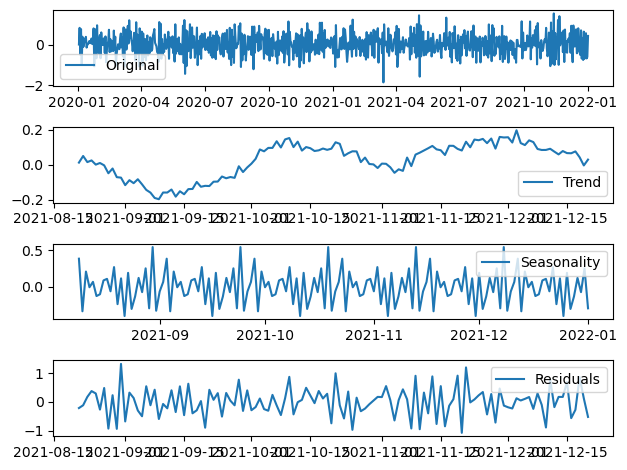

In [50]:
#Plot the decomposition of the Time Series for Test Dataset
decomp_result = seasonal_decompose(df_test['Revenue'], model='additive', period = 25)

trend_t = pd.Series(decomp_result.trend)
season_t = pd.Series(decomp_result.seasonal)
res_t = pd.Series(decomp_result.resid)

plt.subplot(411)
plt.plot(df_final, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_t, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(season_t, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(res_t, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

#### Model Comparison based on the AR, SARIMAX, and auto_arima model for model selection.

In [51]:
#AR Model Summary
print(results_train.summary())

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -383.946
Date:                Sat, 19 Aug 2023   AIC                            773.893
Time:                        13:13:58   BIC                            787.002
Sample:                    01-03-2020   HQIC                           779.002
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0234      0.013      1.758      0.079      -0.003       0.049
ar.L1         -0.4597      0.036    -12.654      0.000      -0.531      -0.388
sigma2         0.2180      0.014     16.034      0.0

In [52]:
#Sarimax Model Summary
print(results_s.summary())
print(results_s.params)

                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -385.495
Date:                Sat, 19 Aug 2023   AIC                            774.990
Time:                        13:13:58   BIC                            783.730
Sample:                    01-03-2020   HQIC                           778.397
                         - 08-08-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4568      0.036    -12.605      0.000      -0.528      -0.386
sigma2         0.2191      0.014     15.965      0.000       0.192       0.246
Ljung-Box (L1) (Q):                   0.02   Jarque-

In [53]:
#Auto ARIMA Summary
print(results_i.summary())
print(results_i.params)

                                    SARIMAX Results                                     
Dep. Variable:                          Revenue   No. Observations:                  584
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -381.794
Date:                          Sat, 19 Aug 2023   AIC                            771.587
Time:                                  13:13:58   BIC                            789.067
Sample:                              01-03-2020   HQIC                           778.400
                                   - 08-08-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.014      1.677      0.093      -0.004       0.052
ar.L1         -0.4680      0.037    -12.555      0.

### D2 ARIMA Model

After performing seasonal decomposition on our train dataset, we did see that there was an indication of seasonality. No trends were visible in both the trend and residual plots. We then reviewed the spectral density, the ACF/PACF visualization, as well as calculating a series of AR models for comparison which gaves us AR(1) as the best model which produced the lowest AIC score. Auto_arima function was then use with parameters set to match the observed trends from the seasonal decomposition. The result indicated that the best model to use was ARIMA(1,0,0)(1,0,0)[90].

### D3-5: Forecast ARIMA Model, Output and Calculations, and Code to Implement Time Series Model

In this step, we will forecast the model suggested by auto_arima. All forecast, outputs/calculations, and code are listed below.

### Code to Implement and Outputs/Calculations


In [54]:
#ARIMA Model
#We will use the ARIMA(1,0,0)(1,0,0)[90] model which was suggested by auto_arima.

model_trainT = ARIMA(df_train, order = (1, 0, 0), 
                     seasonal_order=(1,0,0,90))
result_trainT = model_trainT.fit()
print(result_trainT.summary())
print(result_trainT.params)

model_testT = ARIMA(df_test, order = (1, 0, 0), 
                     seasonal_order=(1,0,0,90))
result_testT = model_testT.fit()

                                    SARIMAX Results                                     
Dep. Variable:                          Revenue   No. Observations:                  584
Model:             ARIMA(1, 0, 0)x(1, 0, 0, 90)   Log Likelihood                -381.794
Date:                          Sat, 19 Aug 2023   AIC                            771.587
Time:                                  13:14:02   BIC                            789.067
Sample:                              01-03-2020   HQIC                           778.400
                                   - 08-08-2021                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0239      0.014      1.677      0.093      -0.004       0.052
ar.L1         -0.4680      0.037    -12.555      0.

### Forecast ARIMA Model

In [55]:
#Forecast ARIMA Model Calculations
diff_forecast = result_trainT.get_forecast(steps=240)
mean_forecast = diff_forecast.predicted_mean
confidence_intervals = diff_forecast.conf_int()
dates = mean_forecast.index
lower_limits = confidence_intervals.loc[:,'lower Revenue']
upper_limits = confidence_intervals.loc[:,'upper Revenue']

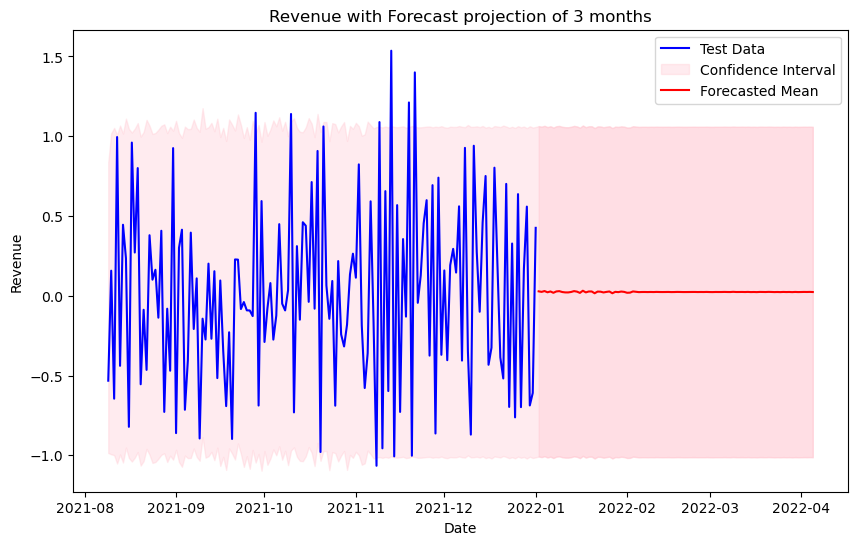

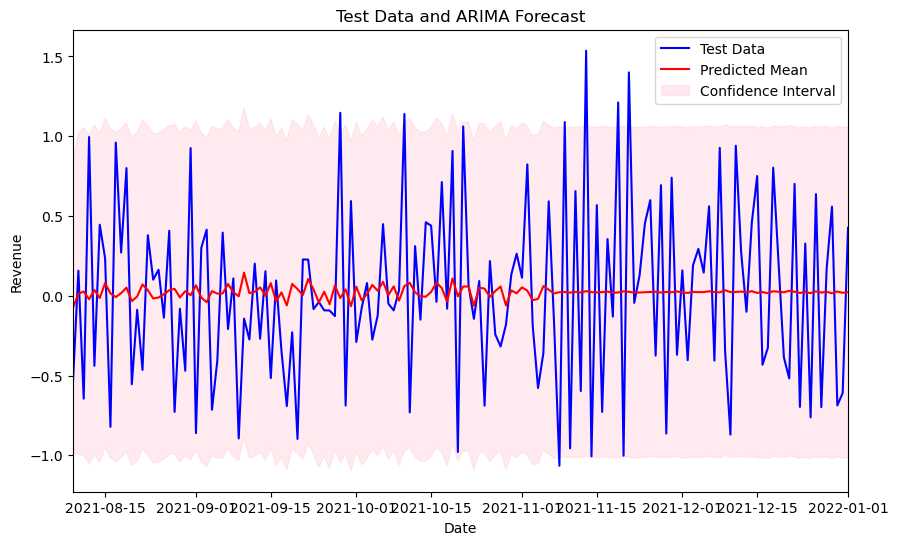

In [56]:
#Forecasting ARIMA Model

# Getting the last date of the test dataset
last_test_date = df_test.index[-1]

# Set dates for predicted means etc..
future_dates = dates[dates > last_test_date]
future_mean = mean_forecast[future_dates]
future_lower_limits = lower_limits[future_dates]
future_upper_limits = upper_limits[future_dates]

# Plotting Future Projection
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['Revenue'], label='Test Data', color='blue')
plt.fill_between(dates, lower_limits, upper_limits, color='pink', alpha=0.3, label='Confidence Interval')
plt.plot(future_dates, future_mean, label='Forecasted Mean', color='red')
plt.fill_between(future_dates, future_lower_limits, future_upper_limits, color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue with Forecast projection of 3 months')
plt.legend()
plt.show()

# Plotting Test dataset and ARIMA Forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['Revenue'], label='Test Data', color='blue')
plt.plot(dates, mean_forecast, label='Predicted Mean', color='red')
plt.fill_between(dates, lower_limits, upper_limits, color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Test Data and ARIMA Forecast')
plt.legend()

# Setting x-axis limits to match test dataset
plt.xlim(df_test.index[0], df_test.index[-1])

plt.show()

#### Forecast Visualization doesn't look too good

### Model Evaluation and Error Metrics

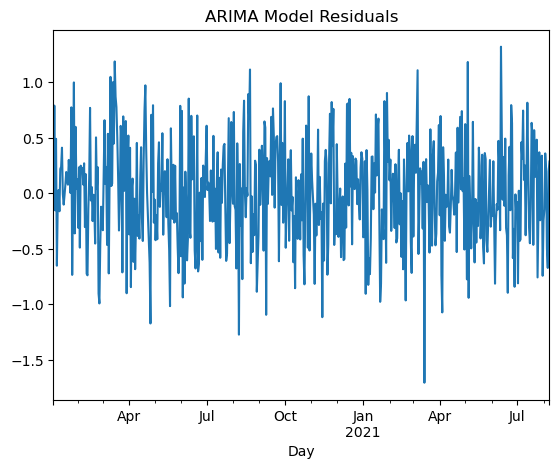

In [57]:
#Get Residual of Model
residuals = result_trainT.resid

residuals.plot()
plt.title('ARIMA Model Residuals')
plt.show()

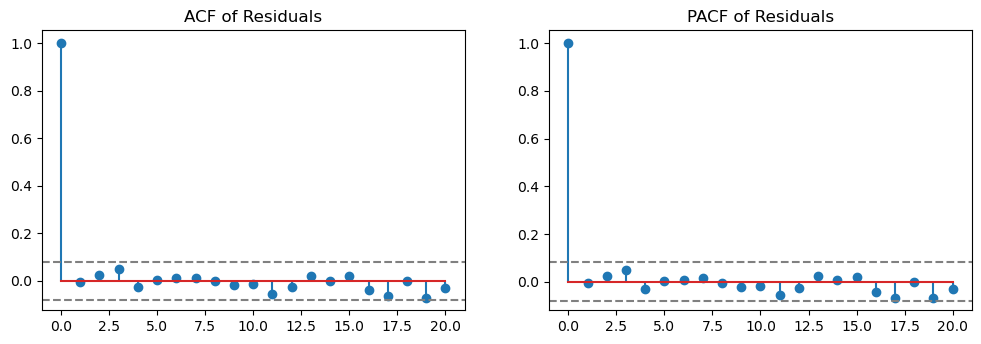

In [58]:
# Calculate ACF and PACF of residuals
acf_res = acf(residuals, nlags=20)
pacf_res = pacf(residuals, nlags=20)

# Plot ACF, PACF's residuals
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.stem(acf_res)
plt.axhline(y=1.96/np.sqrt(len(residuals)), color='gray', linestyle='--')  # Upper confidence interval(CI) band
plt.axhline(y=-1.96/np.sqrt(len(residuals)), color='gray', linestyle='--')  # Lower CI band
plt.title('ACF of Residuals')
plt.subplot(2, 2, 2)
plt.stem(pacf_res)
plt.axhline(y=1.96/np.sqrt(len(residuals)), color='gray', linestyle='--')  # Upper CI band
plt.axhline(y=-1.96/np.sqrt(len(residuals)), color='gray', linestyle='--')  # Lower CI band
plt.title('PACF of Residuals')
plt.show()

In [59]:
# Predictions against the test set
predictions = result_trainT.predict(start=start, end=end,
                             typ = 'levels')
print(predictions)

2021-08-09   -0.074263
2021-08-10    0.012736
2021-08-11    0.026811
2021-08-12   -0.021288
2021-08-13    0.036116
                ...   
2021-12-28    0.025436
2021-12-29    0.015644
2021-12-30    0.027075
2021-12-31    0.019104
2022-01-01    0.022724
Freq: D, Name: predicted_mean, Length: 146, dtype: float64


In [60]:
# Calculate mean squared error
mse = mean_squared_error(df_test, predictions)

# Calculate root mean squared error
rms = sqrt(mse)
print('Mean', df_test["Revenue"].mean())
print('MSE: ', mse)
print('RMSE: ', rms)

Mean 0.020109401301369855
MSE:  0.32649455891595164
RMSE:  0.5713970238949023


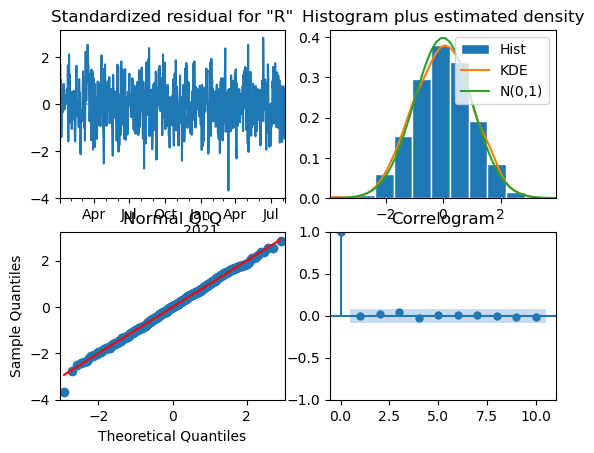

In [61]:
#Plot diagnostic of Model
result_trainT.plot_diagnostics()
plt.show()

### FB Prophet Model visualization for Model Comparison

In [62]:
# Load time series data for Model Comparison with Facebook Prophet
data_f = pd.read_csv('d213_teleco_time_series.csv')
data_f['Day'] = pd.to_datetime(data_f['Day'], unit = 'D', origin = '2020-01-01')
data_f.rename(columns={'Day': 'ds', 'Revenue': 'y'}, inplace=True)
data_f

,ds,y
0,2020-01-02,0.000000
1,2020-01-03,0.000793
2,2020-01-04,0.825542
3,2020-01-05,0.320332
4,2020-01-06,1.082554
...,...,...
726,2021-12-28,16.931559
727,2021-12-29,17.490666
728,2021-12-30,16.803638
729,2021-12-31,16.194813


13:14:06 - cmdstanpy - INFO - Chain [1] start processing
13:14:06 - cmdstanpy - INFO - Chain [1] done processing


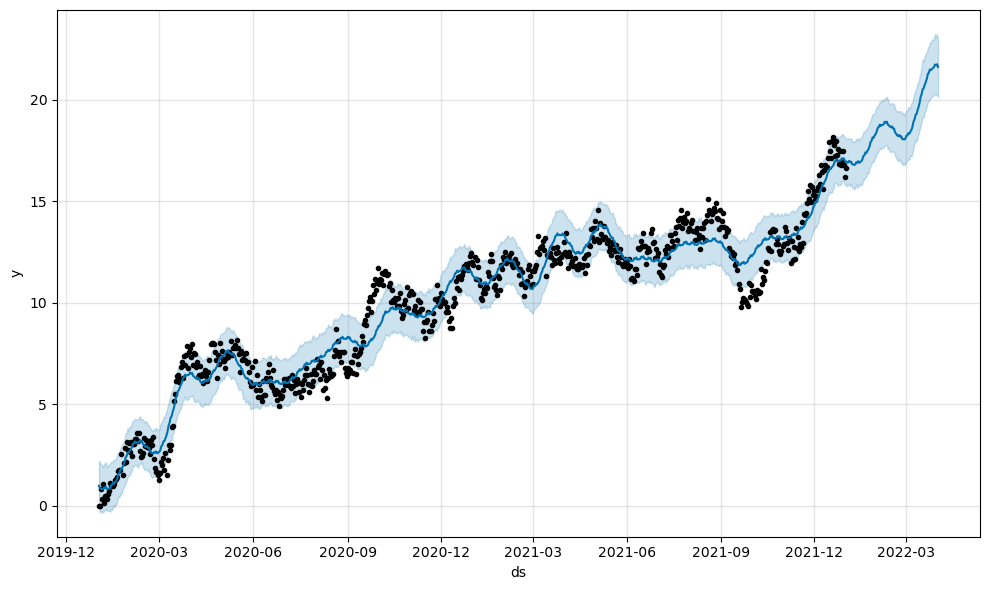

In [63]:
#Model and Predict using Facebook Prophet for model comparison
model_prophet = Prophet()
model_prophet.fit(data_f)
# Make future predictions
future = model_prophet.make_future_dataframe(periods=90)
forecast = model_prophet.predict(future)
# Visualize forecasted data
model_prophet.plot(forecast)
plt.show()

## Part V: Data Summary and Implications

### E1. Result of the Analysis

In [64]:
# Summarize forecast, confidence, and Prediction intervals
df_interval = result_trainT.get_forecast()
print('Expected: %.3f' % df_interval.predicted_mean)
print('Forecast: %.3f' % df_test.iloc[0])
print('Standard Error: %.3f' % df_interval.se_mean)
ci = result_trainT.conf_int(0.05)
print('95%% Interval: %.3f to %.3f' % (ci.iloc[0,0], ci.iloc[0,1]))

Expected: -0.074
Forecast: -0.532
Standard Error: 0.465
95% Interval: -0.004 to 0.052


In [65]:
#Print Prediction Interval
prediction1 = result_testT.get_prediction(start=-35)
mean_forecast1 = prediction1.predicted_mean
confidence_intervals1 = prediction1.conf_int()
lower_limits1 = confidence_intervals1.loc[:,'lower Revenue']
upper_limits1 = confidence_intervals1.loc[:,'upper Revenue']
print(mean_forecast1)

2021-11-28   -0.280148
2021-11-29    0.415215
2021-11-30   -0.312883
2021-12-01    0.228687
2021-12-02   -0.092160
2021-12-03    0.274147
2021-12-04   -0.006967
2021-12-05   -0.131823
2021-12-06   -0.041597
2021-12-07   -0.252418
2021-12-08    0.300895
2021-12-09   -0.391867
2021-12-10    0.232568
2021-12-11    0.466513
2021-12-12   -0.431301
2021-12-13   -0.109189
2021-12-14    0.115508
2021-12-15   -0.188175
2021-12-16   -0.325444
2021-12-17    0.316219
2021-12-18    0.240147
2021-12-19   -0.297089
2021-12-20   -0.055361
2021-12-21    0.200518
2021-12-22    0.290992
2021-12-23   -0.316964
2021-12-24    0.392085
2021-12-25   -0.123638
2021-12-26    0.430013
2021-12-27   -0.373509
2021-12-28    0.392572
2021-12-29   -0.073397
2021-12-30   -0.252041
2021-12-31    0.396028
2022-01-01    0.336270
Freq: D, Name: predicted_mean, dtype: float64


The ARIMA model was selected based on a review of ACF/PACF visualization as well as running a series of AR models comparison (which define AR(1) as the best candidate with the lowest score of AIC=773.89, BIC=787.00). An auto_arima function was also used which identified ARIMA(1,0,0)(1,0,0,90) as the best fit model.

The forecast prediction interval shown above, followed our dataset in intervals of days within a two year span. Using the summary above, we can say our predicted interval should fall within the 95% Confidence interval range (Stephanie, 2023).

Since we only have 2 years of historical data, any forecast justification pass that length of time would be challenging and carries certain risks (Appendix A: FAQs - Time Series Forecasting Principles With Amazon Forecast, n.d.). For our model, since we only have 730 observation within a two year span, we used a moderate forecast horizon of 90 days or 3 months.

The model's evaluation procedure was done via AR Model comparison which gave us the model with the best AIC as well as Auto-ARIMA to find a suitable seasonal order. Residual analysis of the ACF and PACF was also evaluated. The error metric (MSE=0.32, RMSE=0.57) indicates that model is not as accurate. Since the test dataset's revenue average hovers around 0.02, we would want a RMSE value far less than that number (Allwright, 2022).

### E2. Annotated Visualization of the Final Model vs. Test Model

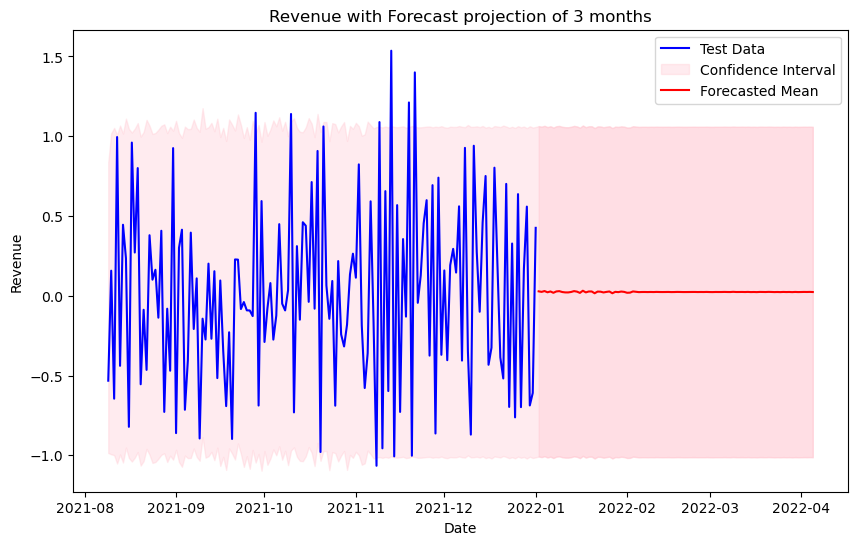

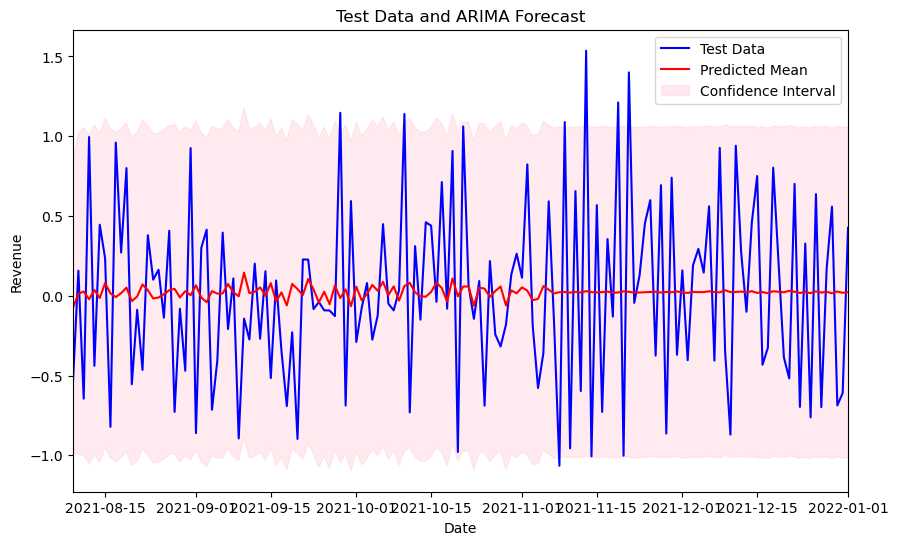

In [66]:
# Getting the last date of the test dataset
last_test_date = df_test.index[-1]

# Set dates for predicted means etc..
future_dates = dates[dates > last_test_date]
future_mean = mean_forecast[future_dates]
future_lower_limits = lower_limits[future_dates]
future_upper_limits = upper_limits[future_dates]

# Plotting Future Projection
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['Revenue'], label='Test Data', color='blue')
plt.fill_between(dates, lower_limits, upper_limits, color='pink', alpha=0.3, label='Confidence Interval')
plt.plot(future_dates, future_mean, label='Forecasted Mean', color='red')
plt.fill_between(future_dates, future_lower_limits, future_upper_limits, color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue with Forecast projection of 3 months')
plt.legend()
plt.show()

# Plotting Test dataset and ARIMA Forecast
plt.figure(figsize=(10, 6))
plt.plot(df_test.index, df_test['Revenue'], label='Test Data', color='blue')
plt.plot(dates, mean_forecast, label='Predicted Mean', color='red')
plt.fill_between(dates, lower_limits, upper_limits, color='pink', alpha=0.3, label='Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Test Data and ARIMA Forecast')
plt.legend()

# Setting x-axis limits to match test dataset
plt.xlim(df_test.index[0], df_test.index[-1])

plt.show()

### E3: Recommended Course of Action

Even though the RMSE value indicated that the model was not as accurate, other values such as the prediction interval indicates that we can predict the range of values with some form of accuracy (Brownlee, 2020b). The future forecast in our model was not usable as it flatline passed a certain date. In conclusion, we were unable to detect any usable patterns in our model and we cannot reasonably predict up to 90 days. Our recommended course of action would be to evaluate other models such as Facebook Prophet and to see if we could potentially find valuable insights so that we can further evaluate our revenue streams and detect any seasonal patterns or trends that may exists.

## Part VI: Reporting

### F. Industry Relevant  Interactive Development Environment

This project was made in Jupyter Notebook

### Part G. Third Party Code

Brownlee, J. (2020b). Understand Time Series Forecast Uncertainty Using Prediction Intervals with Python. MachineLearningMastery.com. https://machinelearningmastery.com/time-series-forecast-uncertainty-using-confidence-intervals-python/

Brownlee, J. (2020). How to Decompose Time Series Data into Trend and Seasonality. MachineLearningMastery.com. https://machinelearningmastery.com/decompose-time-series-data-trend-seasonality/

Danalytix. (2022, November 12). Auto ARIMA and ARIMAX Time Series prediction + forecast | Python [Video]. YouTube. https://www.youtube.com/watch?v=HmN2Hrx6Ocw

Elleh, F. (n.d.-b). Welcome to D213 Advance Data Analytics - Task 1 [Slide show]. https://srm.file.force.com/servlet/servlet.FileDownload?retURL=https%3A%2F%2Fsrm--c.vf.force.com%2Fapex%2FFDP%2FCommonsExpandedChatter%3Fcode%3DD213&file=00P3x00001mir2aEAA&_CONFIRMATIONTOKEN=VmpFPSxNakF5TXkwd09DMHlNbFF4T0Rvd056bzFOeTQzT0RKYSx5aGxRSVpnS20tMHhFSHJqWmZGV21zbmt1cFpvejg1dkxxMmZSZUFnSVl3PSxZVEJoTmpobQ%3D%3D&common.udd.actions.ActionsUtilORIG_URI=%2Fservlet%2Fservlet.FileDownload

G, V. K. (2023). Statistical tests to check stationarity in time series. Analytics Vidhya. https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/#What_Is_a_Stationary_Series?

GeeksforGeeks. (2020). Python ARIMA model for Time series Forecasting. GeeksforGeeks. https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/

InfluxData. (2021, December 10). InfluxDB: Open Source Time Series Database | InfluxData. https://www.influxdata.com/blog/autocorrelation-in-time-series-data/

Let’s forecast interest rates | Python. (n.d.). DataCamp. https://campus.datacamp.com/courses/time-series-analysis-in-python/autoregressive-ar-models?ex=8

Nachiketa Hebbar. (2020, September 5). ARIMA Model In Python| Time Series Forecasting #6| [Video]. YouTube. https://www.youtube.com/watch?v=8FCDpFhd1zk

Nik. (2023). How to calculate a rolling average (Mean) in Pandas. Datagy. https://datagy.io/rolling-average-pandas/

PythonMaster. (2023, February 24). Time Series Analysis and Forecasting with Python: A Comprehensive Guide - PythonBaba.com. PythonBaba.com. https://pythonbaba.com/time-series-analysis-and-forecasting-with-python/#Time_series_analysis_and_forecasting_with_Python

Vincent, T. (2017). A Guide to Time Series Forecasting with ARIMA in Python 3. DigitalOcean. https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

Zach. (2020). How to calculate autocorrelation in Python. Statology. https://www.statology.org/autocorrelation-python/

### H. Sources

6.4.4.2. stationarity. (n.d.). https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc442.htm#:~:text=A%20common%20assumption%20in%20many,do%20not%20change%20over%20time.

Allwright, S. (2022). How to interpret RMSE (simply explained). Stephen Allwright. https://stephenallwright.com/interpret-rmse/

Appendix A: FAQs - Time Series Forecasting Principles with Amazon Forecast. (n.d.). https://docs.aws.amazon.com/whitepapers/latest/time-series-forecasting-principles-with-amazon-forecast/appendix-a-faqs.html

Stephanie. (2023, March 9). Prediction Interval: Simple definition, Examples - Statistics How to. Statistics How To. https://www.statisticshowto.com/prediction-interval/